In [222]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Linear, MSELoss, Sequential, Sigmoid, Softmax, ReLU, LeakyReLU, Module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from scipy.interpolate import make_interp_spline, BSpline

In [223]:
df = pd.read_csv('elapsed-time-experimental-group.csv')
df

,vms,elapsed
0,10,19.7
1,10,17.7
2,10,30.2
3,20,28.7
4,20,35.0
5,20,27.5
6,30,44.3
7,30,41.1
8,40,69.2
9,40,53.1


In [224]:
df = df.dropna() # drop all rows that have NAN/none

In [225]:
df.corr()

,vms,elapsed
vms,1.000000,0.882078
elapsed,0.882078,1.000000


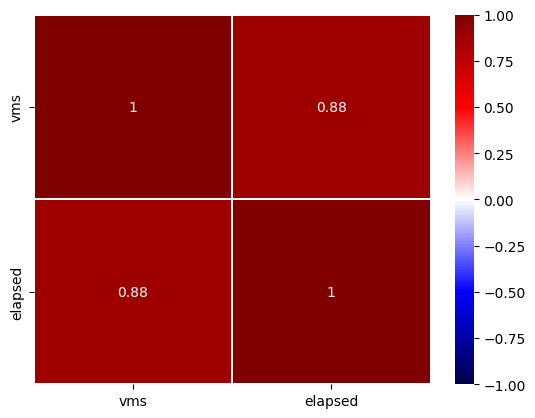

In [226]:
# plt.figure(figsize=(10,10))
sb.heatmap( df.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.2, cmap='seismic' )
plt.show()

In [227]:
df = df.dropna() # drop all rows that have NAN/none
df.insert(0, "squared_vms", df['vms']**2, True)
df

,squared_vms,vms,elapsed
0,100,10,19.7
1,100,10,17.7
2,100,10,30.2
3,400,20,28.7
4,400,20,35.0
5,400,20,27.5
6,900,30,44.3
7,900,30,41.1
8,1600,40,69.2
9,1600,40,53.1


In [228]:
x_data = df.iloc[:,:2].values # 0, 1 열 (x^2 + x)
y_data = df.iloc[:,[-1]].values  # 마지막 열만
print(x_data.shape)

(15, 2)


In [229]:
scaleF = MinMaxScaler()
x_dataN = scaleF.fit_transform( x_data )

scaleL = MinMaxScaler()
y_dataN = scaleL.fit_transform( y_data )
y_dataN.shape

x_dataN

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.125     , 0.25      ],
       [0.33333333, 0.5       ],
       [0.33333333, 0.5       ],
       [0.625     , 0.75      ],
       [0.625     , 0.75      ],
       [0.625     , 0.75      ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ]])

In [230]:
x = torch.FloatTensor(x_dataN) # 특성 데이터
y = torch.FloatTensor(y_dataN) # 라벨

In [231]:
class ExpModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2,1)
    
    def forward(self, x):        
        x = self.fc1(x)
        
        return x   

In [232]:
# model = Sequential()
# model.add_module('nn1', Linear(1,1))
model = ExpModel()
list(model.parameters())

[Parameter containing:
 tensor([[0.6508, 0.3928]], requires_grad=True),
 Parameter containing:
 tensor([0.3219], requires_grad=True)]

In [233]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters())

In [234]:
hist = []
for step in range(3000):
    optimizer.zero_grad()
    hx = model.forward(x) # w*x+b # hx = model(x)
    cost = loss_fn(hx, y)
    cost.backward()
    optimizer.step()
    if step % 100 == 0:
        print(step, cost.item())
    hist.append(cost.item())

0 0.2437995970249176
100 0.09733428806066513
200 0.03942311555147171
300 0.02294653095304966
400 0.019529830664396286
500 0.018818097189068794
600 0.01850353367626667
700 0.01826784946024418
800 0.018082046881318092
900 0.017940301448106766
1000 0.017836034297943115
1100 0.017761847004294395
1200 0.017710531130433083
1300 0.017675744369626045
1400 0.01765231229364872
1500 0.01763630472123623
1600 0.017624864354729652
1700 0.017616072669625282
1800 0.017608681693673134
1900 0.01760193519294262
2000 0.017595384269952774
2100 0.017588792368769646
2200 0.017582034692168236
2300 0.01757504604756832
2400 0.01756780408322811
2500 0.017560278996825218
2600 0.017552489414811134
2700 0.017544418573379517
2800 0.01753607764840126
2900 0.017527466639876366


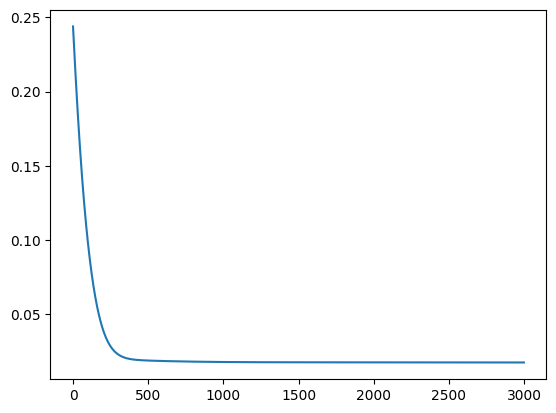

In [235]:
plt.plot(hist)
plt.show()

In [236]:
list(model.parameters())

[Parameter containing:
 tensor([[0.5441, 0.1644]], requires_grad=True),
 Parameter containing:
 tensor([0.0345], requires_grad=True)]

## w,b검정지표: 결정계수(선형회귀)
- 0 <= 결정계수 <= 1 (0.5 이상이면 예측으로 활용가능하다.)
- 1 - (오차의 제곱합)/(편차의 제곱합)
- 오차: 실제 값과 예측 값의 차이
- 편차: 실제 값과 평균 값의 차이

In [237]:
pred = model(x).detach().numpy()
pred

array([[0.03448357],
       [0.03448357],
       [0.03448357],
       [0.14360024],
       [0.14360024],
       [0.14360024],
       [0.29806012],
       [0.29806012],
       [0.49786314],
       [0.49786314],
       [0.49786314],
       [0.7430093 ],
       [0.7430093 ],
       [0.7430093 ],
       [0.7430093 ]], dtype=float32)

In [238]:
r2_score(y_dataN, pred)

0.8089341726492729

In [239]:
# Dummy data to draw smooth graph
x_axis = np.linspace(1,50,50) # [ 1 , 2, 3, 4, ...., 50]
x_dummy = [[xval**2, xval] for xval in x_axis]
scaleF = MinMaxScaler()
x_dummyN = scaleF.fit_transform( x_dummy )

y_dummyN = model(torch.FloatTensor(x_dummyN)).detach().numpy()
y_dummy = scaleL.inverse_transform(y_dummyN)

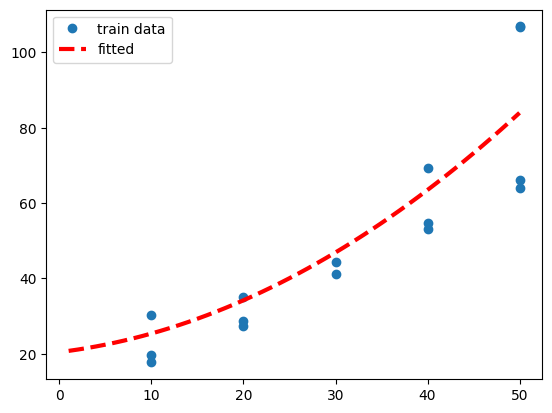

In [240]:
# plt.ylim([0, 25000])
plt.plot(x_data[:,[1]], y_data, 'o', label='train data')
# plt.scatter(x_data, y_data)
# plt.plot(x_data[:,1], np.exp(model(x).data.numpy()), '-r', linewidth=3, label='fitted') # r-- : Red, dashed line

plt.plot(x_axis, y_dummy, 'r--', linewidth=3, label='fitted') # r-- : Red, dashed line
# plt.grid()
plt.legend()
plt.show()